# Two Traveling Salespeople

Name: Cody Lam

I understand that my submission needs to be my own work: yes

Points: 10

## Two-person Version of the [Traveling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem)

* __Goal:__ Find the two tours which collectively visit each of $n$ cities exactly once and return back to the same starting city. Given are pairwise distances between cities, where $d_{i,j}$ is the distance from city $i$ to city $j$.

* __State space:__ Each state represents a pair of tours, where the first element of the pair are the cities to visit for the first person and the second element are the cities to visit for the second person. The cities are numbered and the tours can be expressed a pair of vectors $(\pi_1, \pi_2)$ with the order in which the cities are visited. That is, $\pi_i(1)$ is the index of the first city to visit by the $i$th person ($i$ either is 1 or 2), $\pi_i(2)$ the index of the second city to visit by the $i$th person, and so on.

* __Objective function:__ Minimize the maximum tour length for both people. Informally, the cities should be divided up roughly evenly between the two people so that neither one has a tour that is too long.

The optimization problem is to find the optimal pair of tours $\pi_1^*$ and $\pi_2^*$ through the $n$ cities and which return to the start cities of each tour:

  > minimize: $\max(\mathrm{tourlength}(\pi_1), \mathrm{tourlength}(\pi_2))$
  where $\mathrm{tourlength}(\pi_i) = d_{\pi_i(n),\pi_i(1)} + \sum_{j = 1}^{n-1} d_{\pi_i(j),\pi_i(j+1)}$
  >
  > subject to: every city must be visited exactly once


## Helper functions

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

np.set_printoptions(precision=2)

np.random.seed(0) # make the results repeatable

In [ ]:
def random_tour_pair(n):
    """Create two random tours with n cities"""

    tour = list(range(n))
    np.random.shuffle(tour)

    split_index = np.random.randint(0, n-1)
    tour1 = tour[:split_index]
    tour2 = tour[split_index:]

    return tour1, tour2

random_tour_pair(10)

In [ ]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

def random_tsp(n):
    """
    Create a random (Euclidean) traveling salesman problem. Choose n points randomly in a 1 x 1 unit square and calulates a
    pairwise Euclidean distance matrix.
    """

    pos = pd.DataFrame({
        "x" : np.random.uniform(size = n),
        "y" : np.random.uniform(size = n)
    })

    dist = squareform(pdist(pos))

    return({"pos": pos, "dist": dist})

tsp = random_tsp(10)

print(f"Positions:\n{tsp['pos']}")
print(f"Distance matrix:\n{pd.DataFrame(tsp['dist'])})")

In [179]:
def tour_pair_max_length(tsp, tour_pair):
   """Calculate the maximum length of a pair of tours, i.e., the objective function."""

   tour0_len = tour_length(tsp, tour_pair[0])
   tour1_len = tour_length(tsp, tour_pair[1])

   return max(tour0_len, tour1_len)

def tour_length(tsp, tour):
    """Calculate the length of a single tour"""
    # Handle empty tour case
    if not tour:
        return 0

    # make sure tour is a Python list (not an array or a numpy.array)
    if not isinstance(tour, list): tour = tour.tolist()

    tl = 0
    dist = tsp["dist"]

    for i in range(len(tour)-1):
        tl += dist[tour[i], tour[i+1]]

    tl += dist[tour[-1], tour[0]]

    return(tl)

np.random.seed(0) # make the results repeatable
tour_pair = random_tour_pair(10)
print(f"objective value: {tour_pair_max_length(tsp, tour_pair)}")

objective value: 2.881937519770044


In [ ]:
def show_2tsp(tsp, tour_pair = None):
    """display the twoperson traveling salesman problem and a tour pair."""

    pos = tsp["pos"]

    plt.scatter(pos["x"], pos["y"], color='black')

    if tour_pair is not None:
      colors = ['red', 'blue']

      for tour, color in zip(tour_pair, colors):
        # make sure tour is a Python list (not an array or a numpy.array)
        if not isinstance(tour, list): tour = tour.tolist()

        print(f"Tour length ({color}): {round(tour_length(tsp, tour), 2)}")
        tour_x_list = [pos.loc[i, 'x'] for i in tour]
        tour_y_list = [pos.loc[i, 'y'] for i in tour]

        # wrap back to start
        tour_x_list.append(tour_x_list[0])
        tour_y_list.append(tour_y_list[0])

        plt.plot(tour_x_list, tour_y_list, color)

    plt.show()

show_2tsp(tsp, tour_pair)

## Steepest-ascent Hill Climbing Search [2 Points]

Come up with reasonable definition for local moves and explain it in text. Implement a steepest-ascent hill climbing strategy. Measure and report the performance of this on 50 random problem instances. Report the average objective function reached over all problem instances, as well as the average number of local moves analyzed.

In [203]:
"""
A local move is defined as a small modification to the current pair of tours that
results in a new valid pair of tours. Some local moves include swapping cities between
the two tours. Another local move is to move one city from on tour to the other and the
final local move is to reverse a segment of one of the tours. In my implementation I used
the swap move where I am swapping cities between two tours.
"""
# Generate neighboring tour pairs by swapping cities between tours and applying 2-opt moves to generate neighbors
def generate_neighbors(tour_pair):
    neighbors = []
    tour1, tour2 = tour_pair

    # Swap a city between the two tours
    for i in range(len(tour1)):
        for j in range(len(tour2)):
            if len(tour1) > 1 and len(tour2) > 1:
                new_tour1, new_tour2 = tour1[:], tour2[:]
                new_tour1[i], new_tour2[j] = new_tour2[j], new_tour1[i] # Where the citys are swapped
                neighbors.append((new_tour1, new_tour2))

    # Apply the two-opt move within each tour
    def two_opt(tour, other_tour):
       # Ensure tour is large enough for 2-opt
        if len(tour) > 2:
            for i in range(len(tour) - 1):
                for j in range(i + 1, len(tour)):
                    new_tour = tour[:i] + tour[i:j+1][::-1] + tour[j+1:]
                    neighbors.append((new_tour, other_tour))

    two_opt(tour1, tour2)
    two_opt(tour2, tour1)

    return neighbors

# Steepest-ascent Hill Climbing Search Algorithm
def steepest_ascent_hill(tsp):
    tour_pair = random_tour_pair(len(tsp['pos']))
    best_value = tour_pair_max_length(tsp, tour_pair)
    moves_analyzed = 0

    while True:
        neighbors = generate_neighbors(tour_pair)
        if not neighbors:
          break
        moves_analyzed += len(neighbors) # Keep track of the moves

        # Find the highest-value successor-state (The shortest distance)
        best_neighbor = min(neighbors, key=lambda t: tour_pair_max_length(tsp, t))
        best_neighbor_value = tour_pair_max_length(tsp, best_neighbor)

        # Compare the values and reassign values
        if best_neighbor_value < best_value:
            tour_pair = best_neighbor
            best_value = best_neighbor_value

        # Otherwise return the current and its the best value
        else:
            break

    return best_value, moves_analyzed

# Run experiment on 50 random instances
num_instances = 50
objective_values = []
moves_analyzed_list = []

for _ in range(num_instances):
    tsp_instance = random_tsp(10)
    obj_value, moves_analyzed = steepest_ascent_hill(tsp_instance)
    objective_values.append(obj_value)
    moves_analyzed_list.append(moves_analyzed)

# Compute average performance metrics
avg_obj_value = np.mean(objective_values)
avg_moves_analyzed = np.mean(moves_analyzed_list)

# Display results
print(f"Average Ojective Value: {avg_obj_value}, Average Moves: {avg_moves_analyzed}")

Average Ojective Value: 2.2228938578977124, Average Moves: 269.98


## Steepest-ascent Hill Climbing Search with Random Restarts [1 Point]

Modify the code to include random restarts once improvement is no longer possible. For a fixed problem instance, analyze the improvement in the objective function as more restarts are done. Plot the number of restarts on the x axis and the objective function on the y axis.

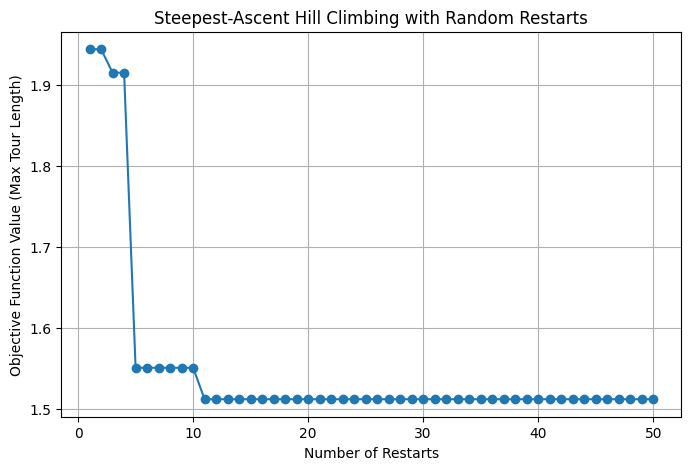

In [108]:
import matplotlib.pyplot as plt

"""
As you can you can see in the graph below, as there are more restarts, the objective value function
will improve and become lower as more restarts are done. The restarts help escape from the local
optima, a standard hill climbing could get stuck on the first local minimum. However, the restarts
allows the algorithm to start from a different random solution anc increase the chance of finding
a better global minimum. Thus, a reason why restarts help improve the performance of the algorithm.
"""

# Modified steepest ascent hill climbing but it uses restarts in order to improve performance
def hill_climbing_with_restarts(tsp, max_restarts=50):
  best_overall_value = float('inf')
  values_per_restart = []

  # Loop through thr given restarts
  for restart in range(max_restarts):
    tour_pair = random_tour_pair(len(tsp["pos"]))
    best_value = tour_pair_max_length(tsp, tour_pair)
    moves_analyzed = 0

    while True:
        # Generate the neighbors
        neighbors = generate_neighbors(tour_pair)

        if not neighbors:
          break

        # Keep track of the moves analyzed and the best neighbor values
        moves_analyzed += len(neighbors)
        best_neighbor = min(neighbors, key=lambda t: tour_pair_max_length(tsp, t))
        best_neighbor_value = tour_pair_max_length(tsp, best_neighbor)

        # Reassign values if a better one was found
        if best_neighbor_value < best_value:
            tour_pair = best_neighbor
            best_value = best_neighbor_value
        else:
            break

    # Keep track of the best objective value so far
    best_overall_value = min(best_overall_value, best_value)
    values_per_restart.append(best_overall_value)

  return values_per_restart

# Display the results in a graph
tsp_instance = random_tsp(10)
values_per_restart = hill_climbing_with_restarts(tsp_instance, max_restarts=50)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 51), values_per_restart, marker='o', linestyle='-')
plt.xlabel("Number of Restarts")
plt.ylabel("Objective Function Value (Max Tour Length)")
plt.title("Steepest-Ascent Hill Climbing with Random Restarts")
plt.grid(True)
plt.show()

## Stochastic Hill Climbing [1 Point]

Implement an approach that chooses randomly from among all uphill moves. Measure and report the performance of this on the same 50 random problem instances as was done earlier. Report the average objective function reached over all problem instances, as well as the average number of local moves analyzed.

In [109]:
import random
"""
In the stochastic hill climbing, you randomly choose a move among the uphill moves,
but it has to be an improving move.
"""
# Randomly chooses an improving move from all the uphill moves
def stochastic_hill_climbing(tsp):
  tour_pair = random_tour_pair(len(tsp['pos']))
  best_value = tour_pair_max_length(tsp, tour_pair)
  moves_analyzed = 0

  while True:
      # Generate neighbors
      neighbors = generate_neighbors(tour_pair)
      if not neighbors:
        break

      moves_analyzed += len(neighbors)

      # Filter only the improving moves
      improving_moves = [t for t in neighbors if tour_pair_max_length(tsp, t) < best_value]

      # If there are no improving moves then stop the search
      if not improving_moves:
          break

      # Choose a random improving move
      tour_pair = random.choice(improving_moves)
      best_value = tour_pair_max_length(tsp, tour_pair)

  return best_value, moves_analyzed

# Test
num_instances = 50
objective_values = []
moves_analyzed_list = []

for _ in range(num_instances):
    tsp_instance = random_tsp(10)
    obj_value, moves_analyzed = stochastic_hill_climbing(tsp_instance)
    objective_values.append(obj_value)
    moves_analyzed_list.append(moves_analyzed)

# Compute average performance metrics
avg_obj_value = np.mean(objective_values)
avg_moves_analyzed = np.mean(moves_analyzed_list)

# Display results
print(f"Average Ojective Value: {avg_obj_value}, Average Moves: {avg_moves_analyzed}")

Average Ojective Value: 2.1653605125328155, Average Moves: 474.4


## First-choice Hill Climbing [1 Point]

First-choice hill climbing is a type of stochastic hill climbing that generates one random local neighbor at a time and accept it if it has a better objective function value than the current state. Implement this and report the performance of on 50 the same random problem instances. Report the average objective function reached over all problem instances, as well as the average number of local moves analyzed.

In [110]:
"""
In a First-choice hill climbing it generates one random local neighbor at a time and then accept if it has a better
objective function value than the current state.
"""
def first_choice_hill_climbing(tsp, max_attempts=100):
  tour_pair = random_tour_pair(len(tsp['pos']))
  best_value = tour_pair_max_length(tsp, tour_pair)
  moves_analyzed = 0

  # Loop based on the max attempts
  for _ in range(max_attempts):
    neighbors = generate_neighbors(tour_pair)

    if not neighbors:
      break

    # Only doing one neighbor at a time
    moves_analyzed += 1

    # Choose a random local neighbor and find its value
    random_neighbor = random.choice(neighbors)
    neighbor_value = tour_pair_max_length(tsp, random_neighbor)

    # Accepts if the random neighbor has a better value than the current one
    if neighbor_value < best_value:
      tour_pair = random_neighbor
      best_value = neighbor_value

  return best_value, moves_analyzed

# Test
num_instances = 50
objective_values = []
moves_analyzed_list = []

for _ in range(num_instances):
    tsp_instance = random_tsp(10)
    obj_value, moves_analyzed = stochastic_hill_climbing(tsp_instance)
    objective_values.append(obj_value)
    moves_analyzed_list.append(moves_analyzed)

# Compute average performance metrics
avg_obj_value = np.mean(objective_values)
avg_moves_analyzed = np.mean(moves_analyzed_list)

# Display results
print(f"Average Ojective Value: {avg_obj_value}, Average Moves: {avg_moves_analyzed}")

Average Ojective Value: 2.1066630027871853, Average Moves: 446.1


## Simulated Annealing [1 Point]

Implement an algorithm that uses simulated annealing to solve the problem, as described in the lectures and book (Section 4.1.2). Experiment with hyperparameters like the temperature schedule and thresholds until you find values that work well.

In [111]:
"""
In a simulated annealing for the two-person tsp, I implemented the three different types of cooling schedules
to test which cooling schedule would performed the best. After running for each schedule, I found that the
Fast Cooling Schedule performed the best with the lowest objective value
"""
import math

def simulated_annealing(tsp, initial_temperature=10.0, cooling_type="classic", alpha=0.95, min_temperature=0.01, max_iterations=1000):
    tour_pair = random_tour_pair(len(tsp['pos']))
    current_value = tour_pair_max_length(tsp, tour_pair)
    best_tour = tour_pair
    best_value = current_value
    temperature = initial_temperature
    moves_analyzed = 0

    # Loop until the max_iteration
    for t in range(1, max_iterations + 1):
        # Once the temperature is below the min temperature, that is when the loop stops
        if temperature < min_temperature:
            break

        # Generate neighbors
        neighbors = generate_neighbors(tour_pair)
        moves_analyzed += 1

        if not neighbors:
            continue

        # Choose a random neighbor and find its value
        random_neighbor = random.choice(neighbors)
        neighbor_value = tour_pair_max_length(tsp, random_neighbor)
        # Find the delta value
        delta = neighbor_value - current_value

        # If delta is less than zero or math.exp(-delta / temperature) > np.random.rand() reassign values
        if delta < 0 or math.exp(-delta / temperature) > np.random.rand():
            tour_pair = random_neighbor
            current_value = neighbor_value

            if current_value < best_value:
                best_tour = tour_pair
                best_value = current_value

        # Different Cooling Schedules
        if cooling_type == "classic": # Classic simulated annealing
            temperature = initial_temperature / math.log(1 + t)
        elif cooling_type == "fast":  # Fast simulated annealing
            temperature = initial_temperature / (1 + t)
        elif cooling_type == "exponential":  # Exponential cooling
            temperature = initial_temperature * (alpha ** t)

    return best_value, moves_analyzed

# This function will compare the different types of cooling schedules
def compare_cooling_schedules(num_instances=50):
    cooling_types = ["classic", "fast", "exponential"]
    results = {c: {"objective_values": [], "moves_analyzed": []} for c in cooling_types}

    for cooling_type in cooling_types:
        for _ in range(num_instances):
            tsp_instance = random_tsp(10)
            obj_value, moves_analyzed = simulated_annealing(tsp_instance, cooling_type=cooling_type)
            results[cooling_type]["objective_values"].append(obj_value)
            results[cooling_type]["moves_analyzed"].append(moves_analyzed)

    # Compute and display performance metrics
    for cooling_type in cooling_types:
        avg_obj_value = np.mean(results[cooling_type]["objective_values"])
        avg_moves_analyzed = np.mean(results[cooling_type]["moves_analyzed"])
        print(f"Cooling Type: {cooling_type.capitalize()}")
        print(f"  - Average Objective Value: {avg_obj_value:.2f}")
        print(f"  - Average Moves Analyzed: {avg_moves_analyzed:.2f}\n")

compare_cooling_schedules()

Cooling Type: Classic
  - Average Objective Value: 2.31
  - Average Moves Analyzed: 1000.00

Cooling Type: Fast
  - Average Objective Value: 2.12
  - Average Moves Analyzed: 1000.00

Cooling Type: Exponential
  - Average Objective Value: 2.25
  - Average Moves Analyzed: 135.00



## Compare Performance [1 Point]

Compare simulated annealing with random restarts and stochastic hill climbing. Analyze which algorithm is better for 10 cities, 20 cities, and 50 cities. To make the comparison fair, try to ensure the time taken for each approach is roughly the same.

For timing you can use the `time` package.

In [ ]:
import time

t0 = time.time()
print("Do something")
t1 = time.time()

print(f"This took: {(t1-t0) * 1e3} milliseconds")

In [96]:
import time
import pandas as pd

# Compare objective values and time of the simulated annealing, random restarts and stochastic hill climbing
def compare_algorithms(city_sizes, num_instances=50):
  results = []

  for n in city_sizes:
    tsp_instance = random_tsp(n)

    # Measure Stochastic Hill Climbing
    start_time = time.time()
    stochastic_results = [stochastic_hill_climbing(tsp_instance) for _ in range(num_instances)]
    stochastic_time = (time.time() - start_time) / num_instances

    # Measure Random Restarts Hilling Climbing
    start_time = time.time()
    restart_results = [hill_climbing_with_restarts(tsp_instance, max_restarts=5) for _ in range(num_instances)]
    restart_time = (time.time() - start_time) / num_instances

    # Measure Simulated Annealing
    start_time = time.time()
    sa_results = [simulated_annealing(tsp_instance, cooling_type="fast") for _ in range(num_instances)]
    sa_time = (time.time() - start_time) / num_instances

    # Computing the average performances
    avg_stochastic_obj = np.mean([res[0] for res in stochastic_results])

    avg_restart_obj = np.mean([min(res) for res in restart_results])

    avg_sa_obj = np.mean([res[0] for res in sa_results])

    # Compute average values
    results.append({
            "Cities": n,
            "Stochastic Obj": avg_stochastic_obj,
            "Stochastic Time (s)": stochastic_time,
            "Restart Obj": avg_restart_obj,
            "Restart Time (s)": restart_time,
            "Simulated Annealing Obj": avg_sa_obj,
            "Simulated Annealing Time (s)": sa_time,
        })

  return pd.DataFrame(results)

city_sizes = [10, 20, 50]
df_results = compare_algorithms(city_sizes, num_instances=50)

df_results

,Cities,Stochastic Obj,Stochastic Time (s),Restart Obj,Restart Time (s),Simulated Annealing Obj,Simulated Annealing Time (s)
0,10,1.964798,0.006593,1.482613,0.007861,1.942388,0.057012
1,20,2.940421,0.041931,2.442214,0.131928,4.807335,0.125331
2,50,4.185702,3.055460,3.512367,5.555302,13.893805,3.067889


As you can see in the table above, the hill climbing with restarts has the best objective value when it came to more cities compared to the other algorithms, but it is much slower. I also noticed that the simulated annealing objective value is much greater when there are more cities. It was also as fast as the stochastic algorithm. However, overall the random restarts algorithm had the best objective value.

## Tour US States [3 points]

Take your best performing approach for 50 cities and try to find the minimum objective value for a modified version of the two salesman problem going around the 48 lower US states. The modification is that both tours must start and end in New York. New York is the only state shared between the two tours.

Each state is considered visited if you can get to its centroid and it is assumed straight line distances between centroids based on GPS coordinates is the way we want to measure distances.

Plot the minimum objective value 2-tsp tours that you find in red and blue, like was done before for the randomly generated points. Print the length of the best tours, as well as the list of indices corresponding to states (Louisiana=0, Maryland=1, ... , see code below).

Loaded from states.pkl
[('Louisiana', 773189.1979394469, -1515002.377525561), ('Maryland', 1979094.0929296287, -383219.5841403244), ('Wisconsin', 789405.1598855292, 7178.093118233844), ('Florida', 1716480.2191801812, -1645210.600897309), ('Georgia', 1548181.6569137496, -1221152.92728593), ('Tennessee', 1227400.6102994615, -915322.7518723847), ('Minnesota', 437251.5679414956, 158022.4684412311), ('Iowa', 536318.2702880212, -303823.8620393781), ('Missouri', 657464.3949930624, -708334.2472004973), ('Michigan', 1154374.0876788201, 31062.850406589027), ('Idaho', -1153546.3198592367, 32306.322358552956), ('California', -1708049.274751084, -667730.6252787685), ('Connecticut', 2216157.7595848595, -1386.5813699763721), ('Texas', 66673.11730108206, -1502504.3982431893), ('Virginia', 1848871.780566167, -594407.8114616707), ('New York', 1957067.0071638965, 68085.33717547444), ('Illinois', 917185.1983259161, -491248.59737063444), ('Montana', -727314.0192655406, 271896.712857685), ('Kentucky', 12904

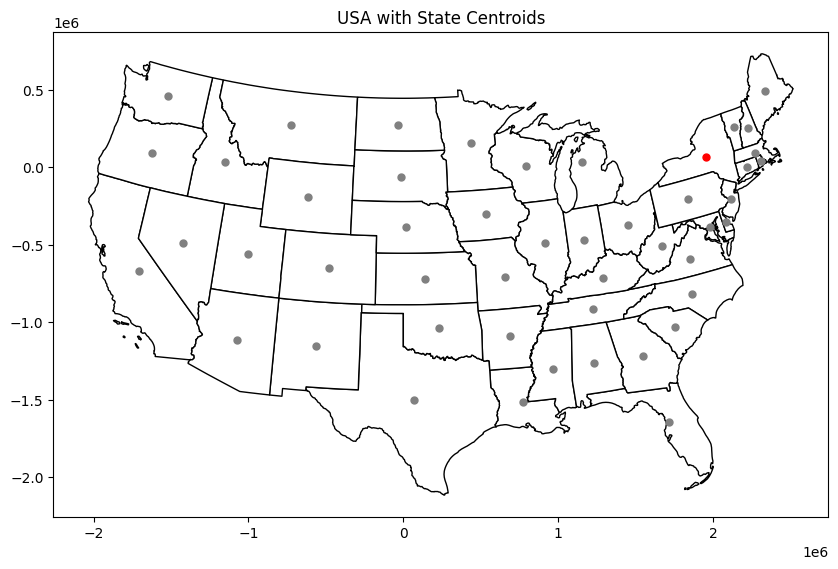

In [161]:
import geopandas as gpd

def get_state_centroids():

    # load pickled data from states.pkl if it exists
    try:
        states = pd.read_pickle('states.pkl')
        print('Loaded from states.pkl')
    except:
        states = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_state_20m.zip')

        # pickle (save) the data to states.pkl so we don't need to download in the future
        states.to_pickle('states.pkl')

        print('Downloaded data and saved to states.pkl')

    # Filter out Alaska, Hawaii, and territories
    contiguous_usa = states[~states['STUSPS'].isin(['AK', 'HI', 'PR', 'GU', 'VI', 'MP', 'AS', 'DC'])]

    # Get centroid data
    contiguous_usa = contiguous_usa.to_crs(epsg=2163)
    centroids = contiguous_usa.geometry.centroid
    contiguous_usa['centroid_lon'] = centroids.x
    contiguous_usa['centroid_lat'] = centroids.y

    # Create tuples (state name, x-coordinate, y-coordinate)
    state_tuples = list(zip(contiguous_usa['NAME'], centroids.x, centroids.y))

    return contiguous_usa, state_tuples

def draw_contiguous_usa_map_with_centroids():
    contiguous_usa, state_tuples = get_state_centroids()

    print(state_tuples)
    print(len(state_tuples))

    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    contiguous_usa.plot(ax=ax, color='white', edgecolor='black')

    # Plot centroids
    for statename, x, y in state_tuples:
        color = 'red' if statename == 'New York' else 'grey'
        plt.plot(x, y, marker='o', color=color, markersize=5)

    plt.title("USA with State Centroids")
    plt.show()

draw_contiguous_usa_map_with_centroids()

Loaded from states.pkl
Best US TSP Tour:
Max Tour Length: 10330542.683608528
Tour 1 Length (Red): 10272318.556992956
Tour 2 Length (Blue): 10330542.683608528

Tour 1: ['New York', 'Vermont', 'Maine', 'New Hampshire', 'Massachusetts', 'Rhode Island', 'Connecticut', 'Pennsylvania', 'Ohio', 'Indiana', 'Illinois', 'Missouri', 'Kansas', 'Nebraska', 'Wyoming', 'Idaho', 'Oregon', 'Washington', 'Montana', 'North Dakota', 'South Dakota', 'Minnesota', 'Iowa', 'Wisconsin', 'Michigan', 'New York']

Tour 2: ['New York', 'New Jersey', 'Delaware', 'Maryland', 'Virginia', 'North Carolina', 'South Carolina', 'Georgia', 'Florida', 'Alabama', 'Mississippi', 'Louisiana', 'Texas', 'New Mexico', 'Arizona', 'California', 'Nevada', 'Utah', 'Colorado', 'Oklahoma', 'Arkansas', 'Tennessee', 'Kentucky', 'West Virginia', 'New York']
Loaded from states.pkl


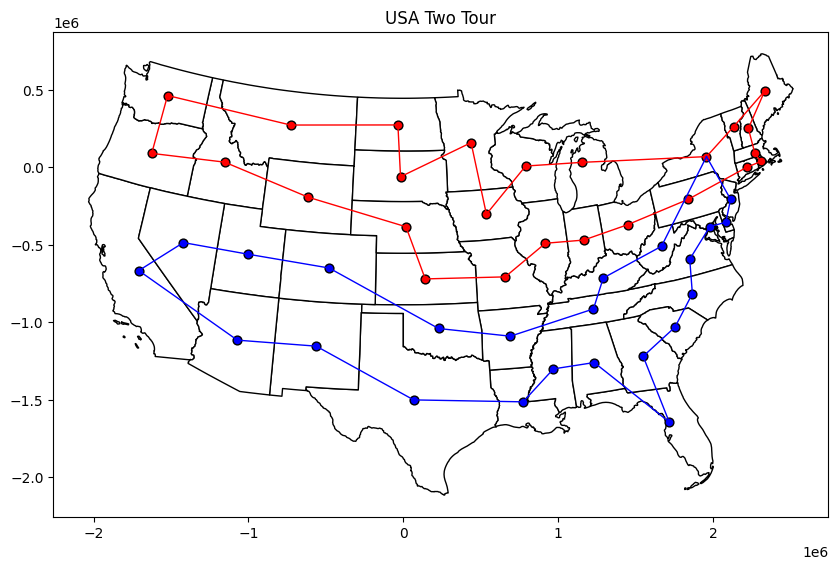

In [205]:
"""
My implementation was to first get the states using the given function and then search for
New York's index. Then using the given number of states I generated a random US tour pair
and ensured that New York was included. I found the distance and the positions and then I
inputted it in the steepest ascent hill with random restarts algorithm and ran with 100 restarts.
Then I displayed it and plotted it on the map.
"""
# Load state centroids and distance matrix
states = get_state_centroids()[1]

# Function to find the index of a given state
def state_index_search(states, state_name):
    for i, state in enumerate(states):
        if state[0] == state_name:
            return i
    return -1

# Get the index of New York
indexNY = state_index_search(states, "New York")

# Function to cycle the tour until New York is the first state
def tour_cycle(tour):
    tour = list(tour)
    while tour[0] != indexNY:
        tour.append(tour.pop(0))

    return tour

# Function to generate a random USA tour pair ensuring New York is included
def usa_tour_pair(num_states):
    all_states = list(range(num_states))

    # Remove New York index so it doesn't get shuffled
    all_states.remove(indexNY)

    random.shuffle(all_states)

    mid = len(all_states) // 2
    t1, t2 = all_states[:mid], all_states[mid:]

    # Ensure New York is in both tours
    t1.insert(0, indexNY)
    t1.append(indexNY)
    t2.insert(0, indexNY)
    t2.append(indexNY)

    return t1, t2

# Function to create the US TSP distance matrix
def usa_tsp():
    x_coords = [state[1] for state in states]
    y_coords = [state[2] for state in states]

    pos = pd.DataFrame({"x": x_coords, "y": y_coords})
    dist = squareform(pdist(pos))

    return ({"pos": pos, "dist": dist})

# Function to translate state indices to state names
def translate_states(tour_pair):
    return (
        [states[i][0] for i in tour_pair[0]],
        [states[i][0] for i in tour_pair[1]]
    )

# Function to plot the optimized 2-TSP solution
def show_usa_2tsp(tsp, tour_pair):
    contiguous_usa, state_tuples = get_state_centroids()

    fig, ax = plt.subplots(figsize=(10, 8))
    contiguous_usa.plot(ax=ax, color='white', edgecolor='black')

    pos = tsp["pos"]

    # Flatten both tours to a single list to check state membership
    tour1, tour2 = set(tour_pair[0]), set(tour_pair[1])

    # Plot centroids with colors based on the tour
    for i, (state_name, x, y) in enumerate(state_tuples):
        if i in tour1:
            color = 'red'
        elif i in tour2:
            color = 'blue'
        else:
            color = 'gray'

        plt.scatter(x, y, color=color, edgecolors='black', s=40)

    # Plot the two tours with the correct colors
    colors = ['red', 'blue']
    for tour, color in zip(tour_pair, colors):
        tour_x = [pos.loc[i, "x"] for i in tour]
        tour_y = [pos.loc[i, "y"] for i in tour]

        # Wrap back to start
        tour_x.append(tour_x[0])
        tour_y.append(tour_y[0])

        plt.plot(tour_x, tour_y, color, linewidth=1)

    plt.title("USA Two Tour")
    plt.show()

# Made another hill climbing with restarts so that it will work with the number of states
def hill_climbing_with_restarts(tsp, max_restarts=100, num_states=48):
    best_overall_value = float("inf")
    best_tour_pair = None

    for restart in range(max_restarts):
        tour_pair = usa_tour_pair(num_states)
        best_value = tour_pair_max_length(tsp, tour_pair)
        moves_analyzed = 0

        while True:
            neighbors = generate_neighbors(tour_pair)
            if not neighbors:
                break

            moves_analyzed += len(neighbors)
            best_neighbor = min(neighbors, key=lambda t: tour_pair_max_length(tsp, t))
            best_neighbor_value = tour_pair_max_length(tsp, best_neighbor)

            if best_neighbor_value < best_value:
                tour_pair = best_neighbor
                best_value = best_neighbor_value
            else:
                break

        if best_value < best_overall_value:
            best_overall_value = best_value
            best_tour_pair = tour_pair

    return best_tour_pair, best_overall_value

# Displaying the information
ustsp = usa_tsp()
ustour_pair = hill_climbing_with_restarts(ustsp)

# Ensure New York is the first state in both tours
ustour_pair = (tour_cycle(list(ustour_pair[0][0])), tour_cycle(list(ustour_pair[0][1])))

tour1_length = tour_length(ustsp, ustour_pair[0])
tour2_length = tour_length(ustsp, ustour_pair[1])

# Print and visualize the best solution
print("Best US TSP Tour:")
print(f"Max Tour Length: {tour_pair_max_length(ustsp, ustour_pair)}")
print(f"Tour 1 Length (Red): {tour1_length}")
print(f"Tour 2 Length (Blue): {tour2_length}")
print("\nTour 1:", translate_states(ustour_pair)[0])
print("\nTour 2:", translate_states(ustour_pair)[1])

show_usa_2tsp(ustsp, ustour_pair)




































---
Assignment adapted from [Michael Hahsler](https://github.com/mhahsler/CS7320-AI) under [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0/deed.en) license.
